## Show and Tell: A Neural Image Caption Generator

Automatically describing the content of an image is a fundamental problem in AI that connects *computer vision* and *natural language processing*.
In this task, we will be looking into how we can use CNNs and RNNs to build an Image Caption Generator.

Specifically, you will be implementing and training the model [in this paper](https://arxiv.org/abs/1411.4555) with TensorFlow/Keras on one of the datasets mentioned in the paper.

To lighten the burden on training the network, you can use any pretrained network in [tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications).

Notes:
- Each image has 5 captions
- We get the vocabulary size in order to generate features of length max(vocab) later on

To run this notebook from Google Colaboratory, please upload the Flickr8k dataset to your drive and update the paths to the dataset accordingly in the next few cells.

You may request for the dataset from: https://forms.illinois.edu/sec/1713398

Steps to achieve this:
1. Process the original dataset (token) to generate the captions for each image. At the same time, generate the vocabulary list and the max caption length that will be used for later steps.
2. Process the images to get the features based on InceptionV3 model.
3. Load the Glove embedding to be used for the text (caption) data. Download the embeddings from https://nlp.stanford.edu/projects/glove/ for glove.6B.200d.txt used in this project
4. Create the data generator function to be used during training.
5. Generate the NIC model - LSTM based.
6. Train the model.
7. Evaluate with bleu score

To run the code:

Please download the dataset and upload to the respective Google drive for it to be able to be loaded and trained in Google Colaboratory.

Else, please change the path accordingly to the local paths in your machine.

## Loading the drive and imports

In [8]:
# Enable the loading of the dataset from drive 
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [9]:
import re
import numpy as np
import os

from collections import defaultdict

import keras 
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from keras.initializers import Constant


Using TensorFlow backend.


In [0]:
# These 3 dataset only gives a list of image file names that is meant
# for each set, change the path accor
train_images = "Flickr8k_text/Flickr_8k.trainImages.txt"
test_images = "Flickr8k_text/Flickr_8k.testImages.txt"
dev_images = "Flickr8k_text/Flickr_8k.devImages.txt"

# The caption file has the structure of
# <image name>#i <caption> with 5 caption lines followed by an empty line
caption_file = "Flickr8k_text/Flickr8k.token.txt"

# this is the prefix to the dataset path in the drive, update accordingly
drive_prefix = "/content/gdrive/My Drive/"
image_path = "Flicker8k_Dataset/"

## Generate captions and Vocabularies

In [0]:
def load_and_process_captions(filename):
    vocabulary = set()
    captions = defaultdict(list)
    caption_max_length = 0
    count = 0
    with open(filename, "r") as f:
        lines = f.readlines()
        print("Total length: {}".format(len(lines)))
        for l in lines:
            if not l:
                continue

            img_id, capt = l.split("\t") # tab-separated
            img_id = img_id.split(".")[0] # retain only the name

            # clean out single characters, there is a lot of "a"
            clean_capt = [
                x for x in re.sub(
                    r'\W+', ' ', capt).strip().lower().split()
                if len(x) > 1
            ]
            
            if len(clean_capt) > caption_max_length:
                caption_max_length = len(clean_capt)

            # Insert start and end marking for LSTM later
            clean_capt.insert(0, "<start>")
            clean_capt.append("<end>")

            vocabulary.update(clean_capt)
            captions[img_id].append(" ".join(clean_capt))

            count += 1
            if count % 1000 == 0:
              print("Count: {}".format(count))
    print("Done processing")
    # convert back to normal dictionary to prevent error later on
    return dict(captions), vocabulary, caption_max_length

In [12]:
caption_path = os.path.join(drive_prefix, caption_file)
captions, vocabulary, caption_max_length = load_and_process_captions(caption_path)
print("Vocabulary size: {}".format(len(vocabulary)))
print("Max length for caption: {}".format(caption_max_length))

Total length: 40460
Count: 1000
Count: 2000
Count: 3000
Count: 4000
Count: 5000
Count: 6000
Count: 7000
Count: 8000
Count: 9000
Count: 10000
Count: 11000
Count: 12000
Count: 13000
Count: 14000
Count: 15000
Count: 16000
Count: 17000
Count: 18000
Count: 19000
Count: 20000
Count: 21000
Count: 22000
Count: 23000
Count: 24000
Count: 25000
Count: 26000
Count: 27000
Count: 28000
Count: 29000
Count: 30000
Count: 31000
Count: 32000
Count: 33000
Count: 34000
Count: 35000
Count: 36000
Count: 37000
Count: 38000
Count: 39000
Count: 40000
Done processing
Vocabulary size: 8466
Max length for caption: 33


## Image Processsing and generate features

In [0]:
def load_images(filename):
    with open(filename, "r") as f:
        lines = f.read().split("\n")
    
    data = [l.split(".")[0] for l in lines]
    return data

In [0]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

# we choose to use inceptionV3 as it is one of the more compact choice
def get_inception_model():
    model = InceptionV3(weights='imagenet')
    
    # retrieve the second last layer
    inceptionv3 = Model(model.input, model.layers[-2].output)
    
    return inceptionv3

def inception_features(image_path, model):
    """
    Takes in an `image_path` and load the image with `preprocess()`.
    Use the `model` to generate the feature vectors.
    """
    image = preprocess(image_path) # preprocess the image
    feature_vec = model.predict(image) # Get the encoding vector for the image
    feature_vec = np.reshape(feature_vec, feature_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return feature_vec

In [0]:
def generate_image_features(image_list, data_path,
                            save_path, returnval=False):
    """
    Takes in a list of images `image_list`, load the image from their location
    `data_path` and generate the feature vector with InceptionV3 model,
    write it to the `save_path` for usage in later steps.
    """
    model = get_inception_model()
    if returnval:
        features = {}
    with open(save_path, "a") as f:
        for img in image_list:
            try:
                print("Processing image: {}".format(img))

                img_path = os.path.join(data_path, "{}.jpg".format(img))
                img_features = inception_features(img_path, model) 
                f.write("{}\t{}".format(img, ",".join([str(i) for i in img_features])))
                f.write("\n")

                if returnval:
                    features[img] = img_features
            except Exception as e:
                print("Failed to generate features for image: {}".format(img))
                print(e)
                continue

    if returnval:
        return features

In [0]:
def load_features(path):
    features = {}
    with open(path, "r") as f:
        while True:
          line = f.readline()
          if len(line) < 1:
              break
          k, v = line.split("\t")
          vec = [float(val) for val in v.split(",")]
          features[k] = vec

    return features

In [0]:
def load_or_generate_features(train_path, test_path, mode="load"):
    """
    Loads or generates the features. 
    Takes in 2 paths, train_path and test_path.
    Mode can either be `train` or `load`
    """

    if mode == "load":
        train_features = load_features(os.path.join(drive_prefix, train_path))
        test_features = load_features(os.path.join(drive_prefix, test_path))
    elif mode == "train":
        train_features = generate_image_features(train_img, os.path.join(drive_prefix, image_path),
                                        os.path.join(drive_prefix, train_path))
        test_features = generate_image_features(test_img, os.path.join(drive_prefix, image_path),
                                        os.path.join(drive_prefix, test_path)) 
    else:
      raise Exception

    return train_features, test_features

In [0]:
test_path = os.path.join(drive_prefix, test_images)
train_path = os.path.join(drive_prefix, train_images)

# define paths to save the feature vectors
train_features_path = "Flickr8k_text/Flickr_8k_train_fea.txt"
test_features_path = "Flickr8k_text/Flickr_8k_test_fea.txt"

test_img = load_images(test_path)
train_img = load_images(train_path)

In [0]:
train_features, test_features = load_or_generate_features(train_features_path,
                                                          test_features_path, "load")

## Text data Processing

In [0]:
def generate_idx_word_mapping(vocabulary):
    word2idx = {}
    idx2word = {}

    idx = 0
    for w in vocabulary:
        word2idx[w] = idx
        idx2word[idx] = w
        idx += 1
        
    return word2idx, idx2word

In [0]:
word2idx, idx2word = generate_idx_word_mapping(vocabulary)

In [0]:
glove_path = os.path.join(drive_prefix, "glove.6B.200d.txt")

In [0]:
def generate_glove_embeddings(glove_path, word2idx, vocab_size,
                              embedding_dim=200):
    # Load Glove vectors
    embeddings_index = {}
    with open(glove_path) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, 'f', sep=' ')
            embeddings_index[word] = coefs

    embedding_mat = np.zeros((vocab_size, embedding_dim))
    for word, idx in word2idx.items():
        if idx > vocab_size:
            continue
        embd_vec = embeddings_index.get(word)
        if embd_vec is not None:
            embedding_mat[idx] = embd_vec
            
    return embedding_mat

In [0]:
embedding_dim = 200
glove_mat = generate_glove_embeddings(glove_path, word2idx, len(vocabulary))

## Data Generator for the model 

In [0]:
def data_generator(captions_all, images, word2idx, idx2word,
                   caption_max_length, vocab_size, batch_size):
    img_input = list()
    txt_input = list()
    y = list()
    
    count = 0
    
    while True:
      for img, image_feature in images.items():
          count += 1
          captions = captions_all[img]
          for caption in captions:
              seq = [word2idx[w] for w in
                      caption.split(" ") if w in word2idx]
              
              """
              generate data as step sequence
              start               1
              start 1             2
              start 1 2           3 
              start 1 ..... n-1   n 
              with padding to max length
              label needs to be converted to categorical as this
              can be seen as classification task for the next seq
              """
              for i in range(len(seq)):
                  _input, _output = seq[:i], seq[i]
                  _input = pad_sequences([_input], maxlen=caption_max_length)[0]
                  _output = to_categorical([_output], num_classes=vocab_size)[0]
                  
                  img_input.append(image_feature)
                  txt_input.append(_input)
                  y.append(_output)
              
          if count % batch_size == 0:
              yield ([np.array(img_input), np.array(txt_input)],
                      np.array(y))
              
              img_input = list()
              txt_input = list()
              y = list()

## Model Architecture

In [0]:
def image_captioning_model(vocab_size, caption_max_length, embedding_matrix,
                           embedding_dim):
    inputs1 = Input(shape=(2048,))  # image input
    # fe1 = Dropout(0.5)(inputs1)     # it is common overfitting
    fe2 = Dense(256, activation='relu')(inputs1)

    # partial caption sequence model
    inputs2 = Input(shape=(caption_max_length,))  # text input
    se1 = Embedding(vocab_size, embedding_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=caption_max_length,
                    trainable=False, mask_zero=True)(inputs2)   # use pretrained glove embeddings
    # se2 = Dropout(0.5)(se1)        # prevent overfitting
    se3 = Dense(256, activation="relu")(se1)
    # se3 = LSTM(256)(se2)

    # decoder (feed forward) model
    decoder1 = add([fe2, se3])
    lstm_layer = LSTM(256)(decoder1)
    decoder2 = Dense(256, activation='relu')(lstm_layer)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # merge the two input models
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    
    return model

In [27]:
NIC_model = image_captioning_model(len(vocabulary), caption_max_length,
                                  glove_mat, embedding_dim)

NIC_model.compile(loss='categorical_crossentropy', optimizer='adam')
NIC_model.summary()




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 33)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 33, 200)      1693200     input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          524544      input_1[0][0]              

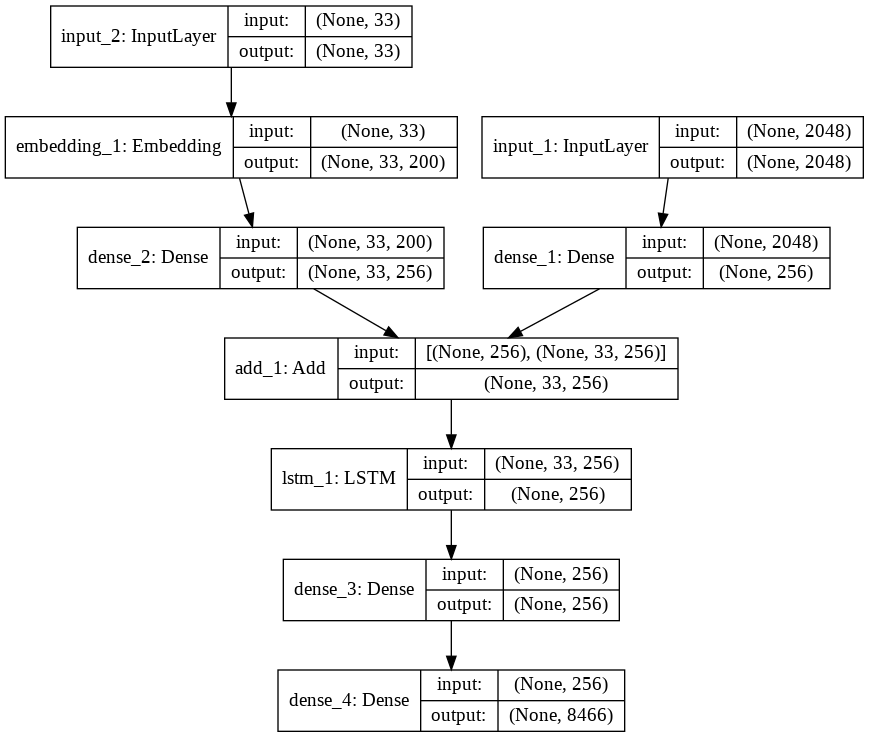

In [28]:
keras.utils.plot_model(NIC_model, "model_no_dropout.png", show_shapes=True)

In [29]:
epochs = 20
number_pics_per_batch = 10
steps = len(captions) / number_pics_per_batch

generator = data_generator(captions, train_features, word2idx, idx2word, caption_max_length, len(vocabulary), number_pics_per_batch)

NIC_model.fit_generator(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)
NIC_model.save(os.path.join(drive_prefix, 'Flickr8k_text/train_model_nodropout{}.h5'.format(epochs)))


# from keras.models import load_model
# NIC_model = load_model(os.path.join(drive_prefix, 'Flickr8k_text/train_model_80.h5'))




Epoch 1/20





810/809 [==============================] - 128s 158ms/step - loss: 5.1384
Epoch 2/20
810/809 [==============================] - 108s 134ms/step - loss: 4.0314
Epoch 3/20
810/809 [==============================] - 101s 124ms/step - loss: 3.5279
Epoch 4/20
810/809 [==============================] - 100s 124ms/step - loss: 3.2386
Epoch 5/20
810/809 [==============================] - 100s 123ms/step - loss: 3.0403
Epoch 6/20
810/809 [==============================] - 99s 122ms/step - loss: 2.8994
Epoch 7/20
810/809 [==============================] - 100s 123ms/step - loss: 2.7690
Epoch 8/20
810/809 [==============================] - 99s 123ms/step - loss: 2.6660
Epoch 9/20
810/809 [==============================] - 100s 123ms/step - loss: 2.5894
Epoch 10/20
810/809 [==============================] - 100s 123ms/step - loss: 2.5020
Epoch 11/20
810/809 [==============================] - 102s 126ms/step - loss: 2.4364
Epoch 12/20
810/809 [==============================] - 10

## Evaluation

In [0]:
def get_caption(model, image, word2idx, idx2word, caption_max_length):
    in_text = '<start>'
    for i in range(caption_max_length):
        seq = [word2idx[w] for w in in_text.split() if w in word2idx]
        seq = pad_sequences([seq], maxlen=caption_max_length)

        yhat = model.predict([[image], seq], verbose=0)
        yhat = np.argmax(yhat)
        word = idx2word[yhat]
        in_text += ' ' + word
        if word == '<end>':
            break
    caption = in_text.split()
    caption = caption[1:-1]
    caption = ' '.join(caption)
    return caption

In [0]:
## Uncomment this cell if you would like to evaluate later on, you will need to save these mappings
# import json

# idx2word_path = os.path.join(drive_prefix, "Flickr8k_text/idx2word_20.txt")
# word2idx_path = os.path.join(drive_prefix, "Flickr8k_text/word2idx_20.txt")

# with open(idx2word_path, "w") as f:
#     json.dump(idx2word, f)

# with open(word2idx_path, "w") as f:
#     json.dump(word2idx, f)

In [0]:
## Uncomment this cell if you are loading from pre-trained
# def load_json(path):
#     with open(path, "r") as f:
#         data = f.read()
#         data = json.loads(data)
#         try:
#             data = {int(k): v for k, v in data.items()}
#         except:
#             data = {k: int(v) for k, v in data.items()}

#     return data

# idx2word_load = load_json(idx2word_path)
# word2idx_load = load_json(word2idx_path)

In [0]:
def beam_search(model, image, word2idx, idx2word, caption_max_length, beam_index = 3):
    in_text = [['<start>',0]]
    eps = 1e-300
    for i in range(caption_max_length):
        temp = []
        for j in range(len(in_text)):
            if in_text[j][0][-5:] == '<end>':
                temp.append(in_text[j])
                continue
            seq = [word2idx[w] for w in in_text[j][0].split() if w in word2idx]
            seq = pad_sequences([seq], maxlen=caption_max_length)
            yhat = model.predict([[image], seq], verbose=0)
            candidates = np.argsort(yhat[0])[-beam_index:]
            for k in range(beam_index):
                word = idx2word[candidates[k]]
                temp.append([in_text[j][0] + ' ' + word, in_text[j][1] + np.log(eps+yhat[0][candidates[k]])])
        temp = sorted(temp, reverse=False, key=lambda l: l[1])
        in_text = temp[-beam_index:]
                
    caption = in_text[0][0].split()
    caption = caption[1:-1]
    caption = ' '.join(caption)
    return caption

In [34]:
get_caption(NIC_model, np.array(test_features[list(test_features.keys())[97]]), word2idx, idx2word, caption_max_length)

'man in black leather jacket and black jacket is standing in front of crowd'

In [35]:
beam_search(NIC_model, np.array(test_features[list(test_features.keys())[97]]), word2idx, idx2word, caption_max_length)

'man in black leather jacket is standing in front of crowd of people'

In [0]:
import json
from nltk.translate.bleu_score import sentence_bleu

def evaluate_bleu(getter, model, test_set, word2idx, idx2word, caption_max_length, save_path=None):
    scores = []
    predicted = {}
    for k, v in test_set.items():
        predicted_caption = getter(NIC_model, v, word2idx, idx2word, caption_max_length)
        actual_captions = captions[k]

        for capt in actual_captions:
            score = sentence_bleu(capt, predicted_caption)
            scores.append(score)

        predicted[k] = predicted_caption

    if save_path is not None:
        with open(save_path, "w") as f:
            json.dump(predicted, f)

    avg_bleu = np.mean(scores)
    print("Average BLEU is: {}".format(avg_bleu))
    return avg_bleu

In [37]:
evaluate_bleu(get_caption, NIC_model, test_features, word2idx, idx2word, caption_max_length,
              os.path.join(drive_prefix, "Flickr8k_text/Flickr_8k_predicted_test_50.txt")
)

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Average BLEU is: 0.7598901723314678


0.7598901723314678

In [38]:
evaluate_bleu(beam_search, NIC_model, test_features, word2idx, idx2word, caption_max_length,
              os.path.join(drive_prefix, "Flickr8k_text/Flickr_8k_predicted_test_50.txt")
)

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Average BLEU is: 0.7283240604523661


0.7283240604523661